# Representações Latentes e Autoencoders

Neste notebook, exploraremos o conceito de representações latentes e como os autoencoders podem ser utilizados para aprendê-las de forma não supervisionada. Abordaremos os seguintes tópicos:

* **Representações Latentes**:
    * Definição formal e o objetivo de aprender representações de dados em espaços de menor dimensionalidade.
    * Visualização do espaço latente com o algoritmo t-SNE (t-Distributed Stochastic Neighbor Embedding).
    * Exemplo prático de treinamento de um codificador (encoder) para a tarefa de classificação e a subsequente visualização de suas representações latentes para o dataset MNIST.

* **Autoencoders**:
    * Arquitetura fundamental de um autoencoder (encoder-decoder).
    * Implementação e treinamento de um autoencoder para reconstruir imagens do MNIST.
    * Visualização de imagens originais e reconstruídas.

* **Denoising Autoencoders**:
    * Conceito e formulação de autoencoders com remoção de ruído.
    * Aplicação prática na remoção de ruído de imagens do MNIST.

## Representações Latentes

No contexto de Deep Learning, uma representação latente é uma codificação interna dos dados de entrada que emerge como resultado do processo de treinamento de uma rede neural para uma tarefa específica. Em vez de ser um resultado de um algoritmo de redução de dimensionalidade pré-definido, o espaço latente é aprendido dinamicamente.

As redes neurais profundas são compostas por uma sequência de camadas. Cada camada executa uma transformação sobre seu dado de entrada, e o resultado é uma representação progressivamente mais abstrata. A saída de qualquer camada intermediária de uma rede pode ser considerada uma representação latente.

A estrutura e as propriedades deste espaço latente são diretamente influenciadas pela função objetivo (loss function) que o modelo otimiza.

Em Aprendizagem Supervisionada (e.g., Classificação), o modelo é treinado para minimizar um erro de classificação (como a Entropia Cruzada). Para isso, o algoritmo de backpropagation ajusta os pesos da rede de forma a transformar os dados de entrada em representações internas que tornem as classes o mais separáveis possível. Um espaço latente ideal, neste caso, agrupará amostras da mesma classe em regiões coesas e distintas, idealmente permitindo uma separação linear por parte das camadas finais da rede. A representação aprende a reter apenas as características discriminativas para a tarefa.

Formalmente, o mapeamento para o espaço latente é uma função parametrizada $\mathbf{z} = f_{\theta}(x)$, onde $\theta$ representa os pesos da rede (o *encoder*) e $\mathbf{z} \in \mathbb{R}^m$ é o vetor latente. Esses parâmetros $\theta$ são aprendidos através da otimização de gradiente descendente para minimizar a função de perda da tarefa final.

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms

# Transformação
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))
])

# Datasets
train_data = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST("./data", train=False, download=True, transform=transform)

# Subsets menores
train_subset = Subset(train_data, torch.randperm(len(train_data))[:10000])
val_subset   = Subset(test_data,  torch.randperm(len(test_data))[:1000])

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=64)

print(len(train_subset), len(val_subset))

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.09MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.48MB/s]

10000 1000


### Treinando um Modelo para Aprender Representações

Para gerar um espaço latente significativo, treinaremos uma Rede Neural na tarefa de classificação do MNIST. As camadas intermediárias desta rede aprenderão a extrair características relevantes dos dados, e a saída de uma dessas camadas servirá como nossa representação latente.

In [4]:
class Classifier(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, latent_dim),
            nn.ReLU(),
        )
        self.classifier_head = nn.Linear(latent_dim, 10)

    def encode(self, x):
        x = self.flatten(x)
        latent = self.encoder(x)
        return latent

    def forward(self, x):
        latent = self.encode(x)
        logits = self.classifier_head(latent)
        return logits

model = Classifier().to(device)
print(model)

Classifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): ReLU()
  )
  (classifier_head): Linear(in_features=64, out_features=10, bias=True)
)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 1/10 | Train Loss: 0.9687, Train Acc: 74.34% | Val Loss: 0.2965, Val Acc: 91.60%
Epoch 2/10 | Train Loss: 0.3635, Train Acc: 89.17% | Val Loss: 0.1954, Val Acc: 93.90%
Epoch 3/10 | Train Loss: 0.2973, Train Acc: 91.13% | Val Loss: 0.1690, Val Acc: 95.10%
Epoch 4/10 | Train Loss: 0.2552, Train Acc: 92.17% | Val Loss: 0.1716, Val Acc: 95.00%
Epoch 5/10 | Train Loss: 0.2192, Train Acc: 93.16% | Val Loss: 0.1459, Val Acc: 95.50%
Epoch 6/10 | Train Loss: 0.1978, Train Acc: 94.09% | Val Loss: 0.1250, Val Acc: 96.40%
Epoch 7/10 | Train Loss: 0.1750, Train Acc: 94.47% | Val Loss: 0.1408, Val Acc: 96.60%
Epoch 8/10 | Train Loss: 0.1626, Train Acc: 94.82% | Val Loss: 0.1349, Val Acc: 96.20%
Epoch 9/10 | Train Loss: 0.1582, Train Acc: 95.05% | Val Loss: 0.1435, Val Acc: 96.00%
Epoch 10/10 | Train Loss: 0.1454, Train Acc: 95.36% | Val Loss: 0.1262, Val Acc: 96.60%


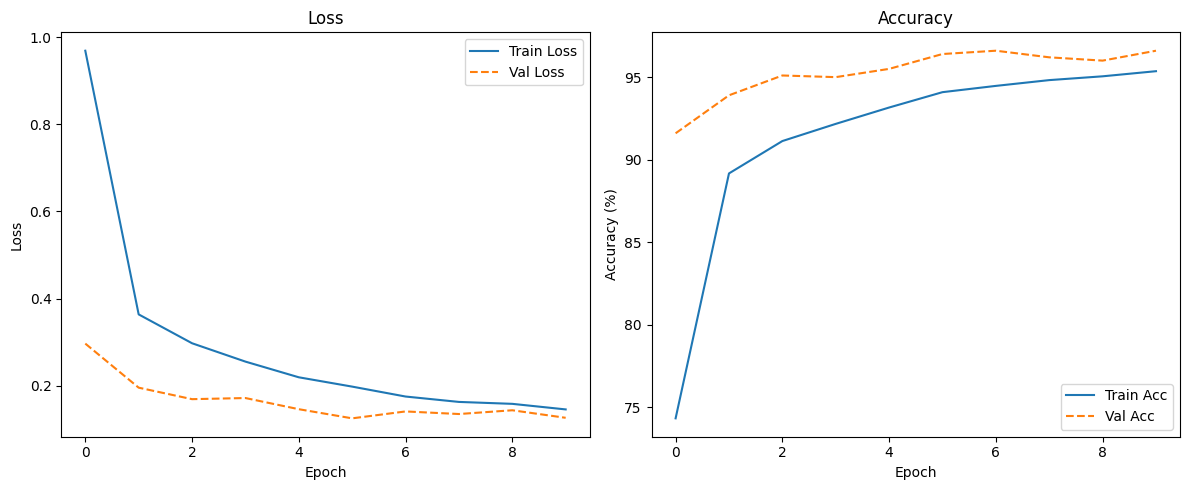

In [6]:
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
epochs = 10

model = model.to(device)

for epoch in range(epochs):
    # ---- Treino ----
    model.train()
    total_loss, correct, total = 0, 0, 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    history["train_loss"].append(total_loss / len(train_loader))
    history["train_acc"].append(100 * correct / total)

    # ---- Validação ----
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    history["val_loss"].append(val_loss / len(val_loader))
    history["val_acc"].append(100 * correct / total)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {history['train_loss'][-1]:.4f}, "
          f"Train Acc: {history['train_acc'][-1]:.2f}% | "
          f"Val Loss: {history['val_loss'][-1]:.4f}, "
          f"Val Acc: {history['val_acc'][-1]:.2f}%")

# ---- Plots ----
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss", linestyle="--")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc", linestyle="--")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

### Visualização com t-SNE

O t-Distributed Stochastic Neighbor Embedding (t-SNE) é um algoritmo não linear de redução de dimensionalidade utilizado primariamente para a visualização de datasets de alta dimensão. Sua principal função é mapear a similaridade entre pontos de dados de um espaço de alta dimensão para um espaço de baixa dimensão (geralmente 2D ou 3D).

O t-SNE modela a probabilidade condicional de que um ponto $x_i$ escolheria $x_j$ como seu vizinho, baseando-se em uma distribuição Gaussiana centrada em $x_i$. Em seguida, ele tenta construir uma distribuição de probabilidade similar sobre os pontos no mapa de baixa dimensão. A otimização é realizada minimizando a divergência de Kullback-Leibler (KL) entre as duas distribuições de probabilidades, a do espaço original e a do espaço de baixa dimensão. O resultado é um mapa que revela a estrutura de clusters dos dados.

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.219s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.994187
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.854694
[t-SNE] KL divergence after 1000 iterations: 0.407160


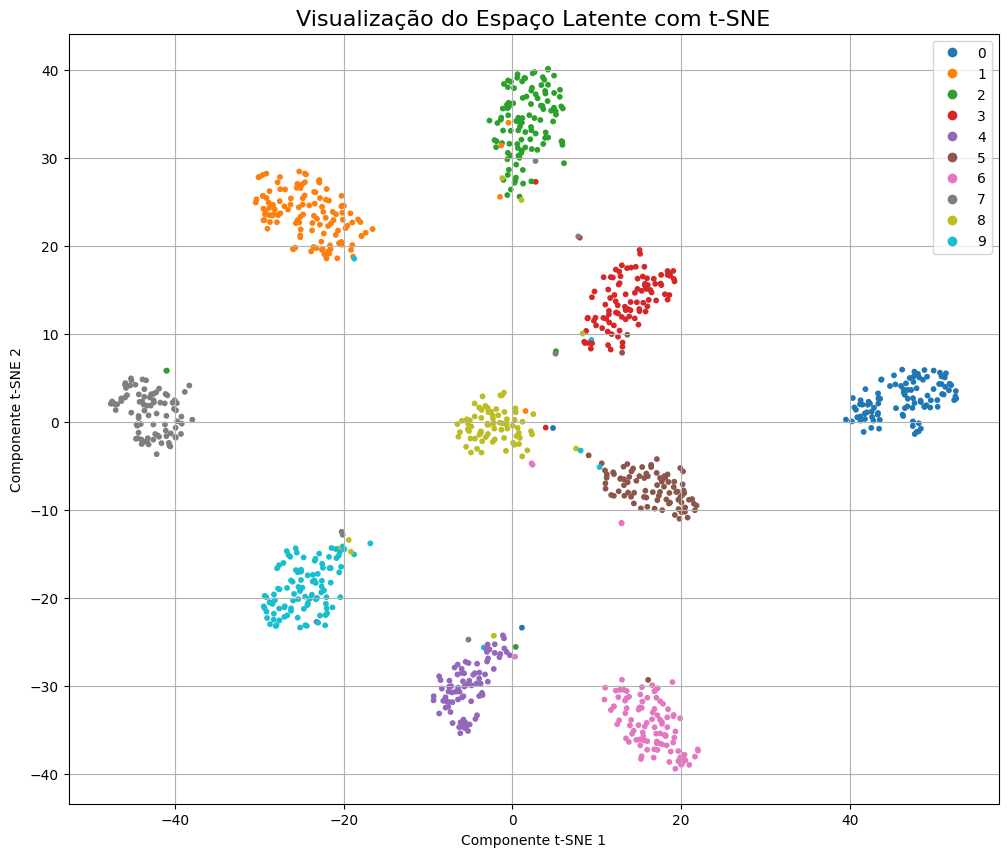

In [7]:
from sklearn.manifold import TSNE

model.eval()
all_latents = []
all_labels = []

with torch.no_grad():
    for X, y in val_loader:
        X = X.to(device)
        latent = model.encode(X)
        all_latents.append(latent.cpu().numpy())
        all_labels.append(y.cpu().numpy())

latent_space_test = np.concatenate(all_latents, axis=0)
labels_test = np.concatenate(all_labels, axis=0)

tsne = TSNE(n_components=2, random_state=42, verbose=1, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(latent_space_test)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels_test, cmap='tab10', s=10)
plt.title('Visualização do Espaço Latente com t-SNE', fontsize=16)
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.legend(handles=scatter.legend_elements()[0], labels=list(range(10)))
plt.grid(True)
plt.show()

## Autoencoders

Um Autoencoder é um tipo de rede neural artificial utilizada para aprender representações de dados de forma não supervisionada. A arquitetura é composta por duas partes principais:

1.  **Encoder ($f$)**: Mapeia a entrada $x$ para uma representação latente $z$ de menor dimensão. $z = f(x)$.
2.  **Decoder ($g$)**: Tenta reconstruir a entrada original a partir da representação latente $z$. $\hat{x} = g(z)$.

O objetivo do treinamento é minimizar o erro de reconstrução, que é a diferença entre a entrada original $x$ e a sua reconstrução $\hat{x}$. Uma função de perda comum para essa tarefa é o Erro Quadrático Médio (Mean Squared Error - MSE).

$$ \mathcal{L}(x, \hat{x}) = \mathcal{L}(x, g(f(x))) = \frac{1}{N} \sum_{i=1}^{N} (x_i - \hat{x}_i)^2 $$

O gargalo informacional imposto pela camada latente força o autoencoder a aprender apenas as variações mais importantes nos dados.

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

ae_model = Autoencoder().to(device)
print(ae_model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [9]:
ae_criterion = nn.MSELoss()
ae_optimizer = torch.optim.Adam(ae_model.parameters(), lr=1e-3, weight_decay=1e-8)

Epoch 1/20, Loss: 0.0851
Epoch 2/20, Loss: 0.0527
Epoch 3/20, Loss: 0.0400
Epoch 4/20, Loss: 0.0360
Epoch 5/20, Loss: 0.0339
Epoch 6/20, Loss: 0.0317
Epoch 7/20, Loss: 0.0302
Epoch 8/20, Loss: 0.0288
Epoch 9/20, Loss: 0.0277
Epoch 10/20, Loss: 0.0270
Epoch 11/20, Loss: 0.0264
Epoch 12/20, Loss: 0.0259
Epoch 13/20, Loss: 0.0255
Epoch 14/20, Loss: 0.0251
Epoch 15/20, Loss: 0.0248
Epoch 16/20, Loss: 0.0246
Epoch 17/20, Loss: 0.0243
Epoch 18/20, Loss: 0.0240
Epoch 19/20, Loss: 0.0237
Epoch 20/20, Loss: 0.0235


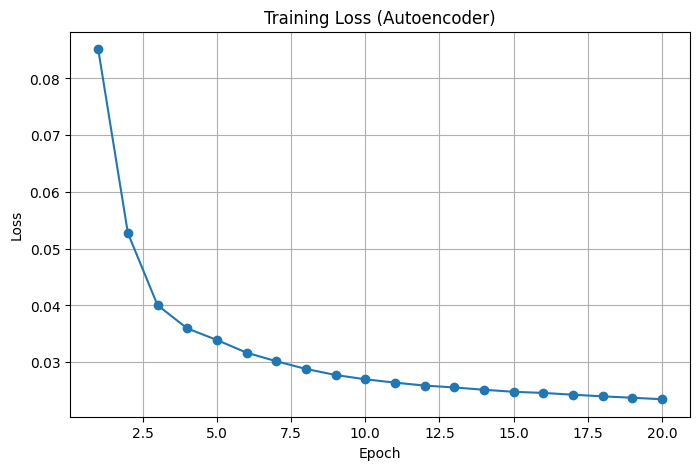

In [10]:
epochs = 20
ae_model.train()

train_losses = []

for epoch in range(epochs):
    epoch_loss = 0.0
    for X, _ in train_loader:
        X = X.view(X.size(0), -1).to(device)

        # Forward
        recon = ae_model(X)
        loss = ae_criterion(recon, X)

        # Backward
        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_losses, marker="o")
plt.title("Training Loss (Autoencoder)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

### Visualização das Reconstruções

Após o treinamento, podemos passar imagens do conjunto de teste pelo autoencoder para obter suas reconstruções. Comparar visualmente as imagens originais com as reconstruídas nos dá uma avaliação qualitativa do desempenho do modelo.

In [11]:
# Visualização das imagens reconstruídas
ae_model.eval()
n = 10

with torch.no_grad():
    # Pega um batch de dados de validação
    data_iter = iter(val_loader)
    images, _ = next(data_iter)
    images_flat = images.view(images.size(0), -1).to(device)

    # Gera as reconstruções
    reconstructed_flat = ae_model(images_flat)

    # Converte para numpy para plotar
    original_images = images.cpu().numpy()
    reconstructed_images = reconstructed_flat.view(-1, 1, 28, 28).cpu().numpy()

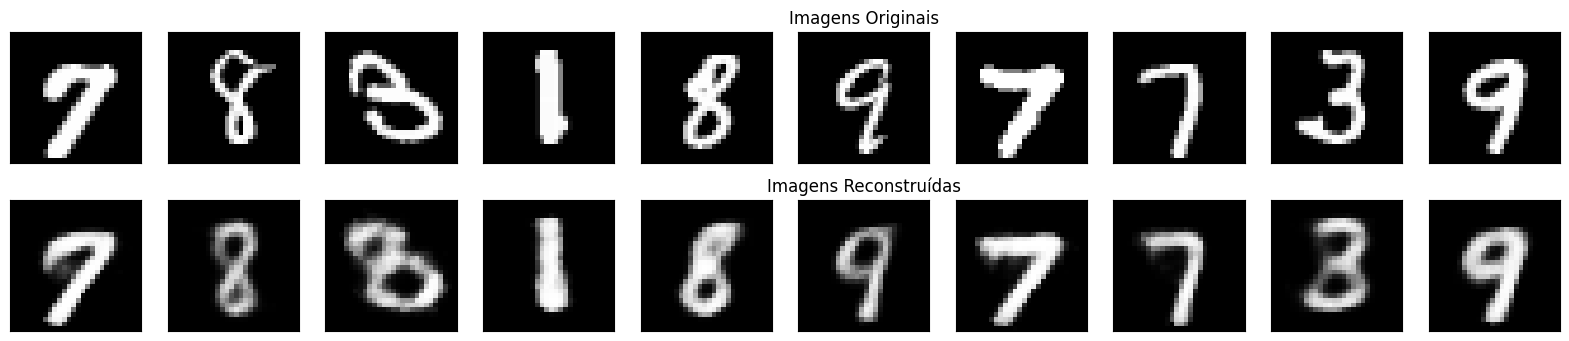

In [12]:
plt.figure(figsize=(20, 4))

for i in range(n):
    # Imagem original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_images[i].squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2:
        ax.set_title('Imagens Originais')

    # Imagem reconstruída
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2:
        ax.set_title('Imagens Reconstruídas')

plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 4.388887
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.936790
[t-SNE] KL divergence after 1000 iterations: 0.957749


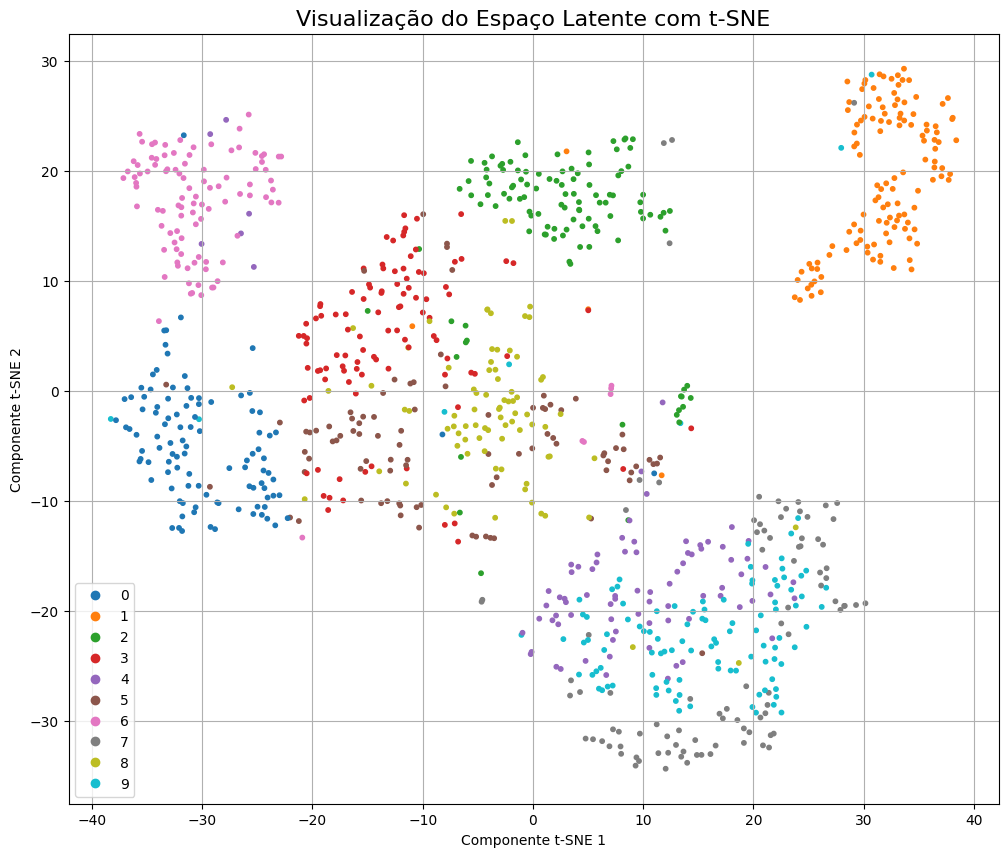

In [13]:
ae_model.eval()
ae_all_latents = []
ae_all_labels = []

with torch.no_grad():
    for X, y in val_loader:
        X = X.view(X.size(0), -1).to(device)
        latent = ae_model.encoder(X)
        ae_all_latents.append(latent.cpu().numpy())
        ae_all_labels.append(y.cpu().numpy())

ae_latent_space_test = np.concatenate(ae_all_latents, axis=0)
ae_labels_test = np.concatenate(ae_all_labels, axis=0)

tsne = TSNE(n_components=2, random_state=42, verbose=1, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(ae_latent_space_test)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels_test, cmap='tab10', s=10)
plt.title('Visualização do Espaço Latente com t-SNE', fontsize=16)
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.legend(handles=scatter.legend_elements()[0], labels=list(range(10)))
plt.grid(True)
plt.show()

## Denoising Autoencoders

Um Denoising Autoencoder é uma variação do autoencoder padrão que é treinado para reconstruir uma entrada limpa a partir de uma versão corrompida (ruidosa) da mesma. A hipótese é que, para realizar essa tarefa, o modelo é forçado a aprender características mais robustas e a extrair a estrutura subjacente dos dados, em vez de simplesmente aprender uma função identidade.

O processo de treinamento envolve:
1.  Corromper a imagem de entrada $x$ para obter $\tilde{x}$.
2.  Alimentar $\tilde{x}$ ao encoder para obter $z = f(\tilde{x})$.
3.  Alimentar $z$ ao decoder para obter a reconstrução $\hat{x} = g(z)$.
4.  Minimizar a perda entre a reconstrução $\hat{x}$ e a imagem original *limpa* $x$.

$$ \mathcal{L}(x, \hat{x}) = \mathcal{L}(x, g(f(\tilde{x}))) $$

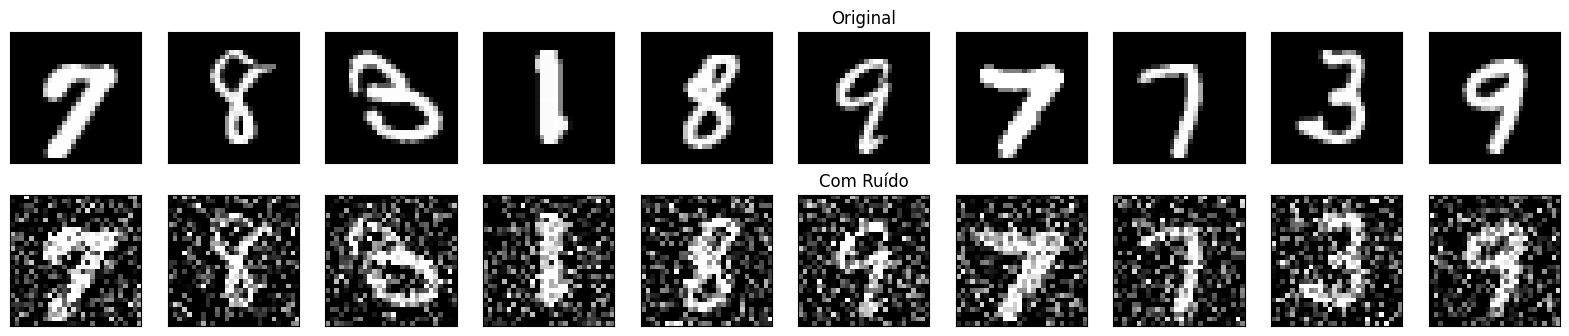

In [14]:
noise_factor = 0.4

data_iter = iter(val_loader)
images, _ = next(data_iter)
images_clean_flat = images.view(images.size(0), -1).to(device)

# Cria a versão com ruído
noise = torch.randn_like(images_clean_flat) * noise_factor
images_noisy_flat = torch.clip(images_clean_flat + noise, 0., 1.)

# Prepara para plotagem
original_imgs = images_clean_flat.cpu().numpy().reshape(-1, 28, 28)
noisy_imgs = images_noisy_flat.cpu().numpy().reshape(-1, 28, 28)

plt.figure(figsize=(20, 6))

for i in range(n):
    # Imagem original (limpa)
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(original_imgs[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2:
        ax.set_title('Original')

    # Imagem com ruído (entrada do modelo)
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_imgs[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2:
        ax.set_title('Com Ruído')

In [15]:
denoising_ae_model = Autoencoder().to(device)
dae_loss_fn = nn.MSELoss()
dae_optimizer = torch.optim.Adam(denoising_ae_model.parameters(), lr=1e-3, weight_decay=1e-8)

Epoch 1/25, Loss: 0.0828
Epoch 2/25, Loss: 0.0637
Epoch 3/25, Loss: 0.0583
Epoch 4/25, Loss: 0.0535
Epoch 5/25, Loss: 0.0471
Epoch 6/25, Loss: 0.0413
Epoch 7/25, Loss: 0.0378
Epoch 8/25, Loss: 0.0360
Epoch 9/25, Loss: 0.0349
Epoch 10/25, Loss: 0.0341
Epoch 11/25, Loss: 0.0332
Epoch 12/25, Loss: 0.0325
Epoch 13/25, Loss: 0.0317
Epoch 14/25, Loss: 0.0309
Epoch 15/25, Loss: 0.0301
Epoch 16/25, Loss: 0.0294
Epoch 17/25, Loss: 0.0287
Epoch 18/25, Loss: 0.0284
Epoch 19/25, Loss: 0.0280
Epoch 20/25, Loss: 0.0277
Epoch 21/25, Loss: 0.0274
Epoch 22/25, Loss: 0.0272
Epoch 23/25, Loss: 0.0269
Epoch 24/25, Loss: 0.0267
Epoch 25/25, Loss: 0.0265


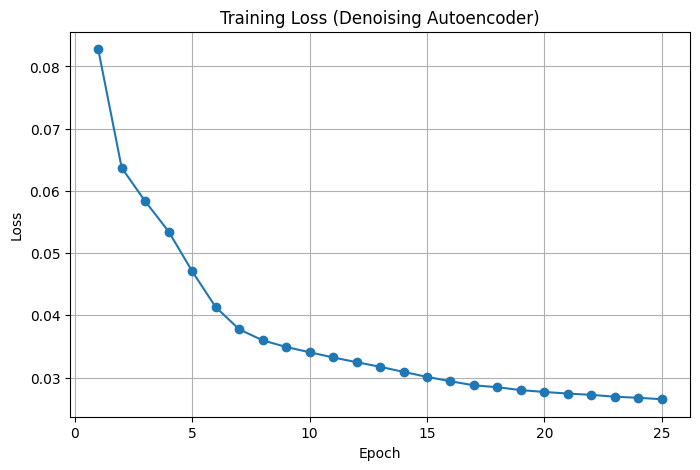

In [16]:
import matplotlib.pyplot as plt

epochs = 25
denoising_ae_model.train()

train_losses = []

for epoch in range(epochs):
    epoch_loss = 0.0
    for X, _ in train_loader:
        X_clean = X.view(X.size(0), -1).to(device)

        # Adiciona ruído
        noise = torch.randn_like(X_clean) * noise_factor
        X_noisy = torch.clamp(X_clean + noise, 0., 1.)

        # Predição e perda (com imagem limpa)
        recon = denoising_ae_model(X_noisy)
        loss = dae_loss_fn(recon, X_clean)

        # Backpropagation
        dae_optimizer.zero_grad()
        loss.backward()
        dae_optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_losses, marker="o")
plt.title("Training Loss (Denoising Autoencoder)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [17]:
denoising_ae_model.eval()
n = 10

with torch.no_grad():
    data_iter = iter(val_loader)
    images, _ = next(data_iter)
    images_clean_flat = images.view(images.size(0), -1).to(device)

    # Cria a versão com ruído
    noise = torch.randn_like(images_clean_flat) * noise_factor
    images_noisy_flat = torch.clip(images_clean_flat + noise, 0., 1.)

    # Gera a reconstrução (denoised)
    denoised_flat = denoising_ae_model(images_noisy_flat)

    # Prepara para plotagem
    original_imgs = images_clean_flat.cpu().numpy().reshape(-1, 28, 28)
    noisy_imgs = images_noisy_flat.cpu().numpy().reshape(-1, 28, 28)
    denoised_imgs = denoised_flat.cpu().numpy().reshape(-1, 28, 28)

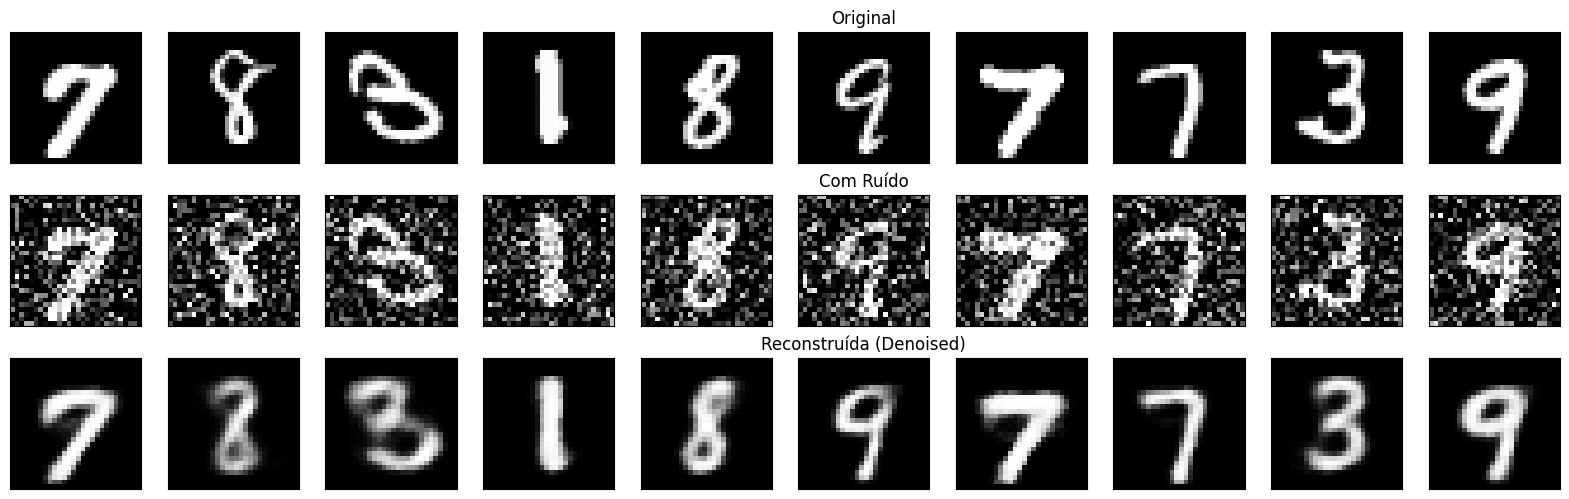

In [18]:
plt.figure(figsize=(20, 6))

for i in range(n):
    # Imagem original (limpa)
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(original_imgs[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2:
        ax.set_title('Original')

    # Imagem com ruído (entrada do modelo)
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_imgs[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2:
        ax.set_title('Com Ruído')

    # Imagem reconstruída (denoised)
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_imgs[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2:
        ax.set_title('Reconstruída (Denoised)')
plt.show()